<center><h1>Liu_Zihan_HW2</h1></center>
<br>
<br>

Name: Zihan Liu
<br>
Github Username: zihan0324
<br>
USC ID: 1534981630

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

Get the Cycle Power Plant Data Set

In [2]:
df_cpp = pd.read_excel('../data/Folds5x2_pp.xlsx', sheet_name='Sheet1')

### (b) Exploring the data

#### i. rows and columns

In [3]:
print("Number of rows in dataset:", df_cpp.shape[0])
print("Number of columns in dataset:", df_cpp.shape[1])

Number of rows in dataset: 9568
Number of columns in dataset: 5


Number of rows means the number of observations in this data set. In this dataset, there are 9568 observations.

Number of columns means the number of predictors and response variable in the data set. In this dataset,

**column 1-4** (['AT', 'V', 'AP', 'RH']) are **predictors**.

**column 5** ('PE') is **response variable**.

#### ii. pairwise scatterplots of all the varianbles

/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/liuzihan/env311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

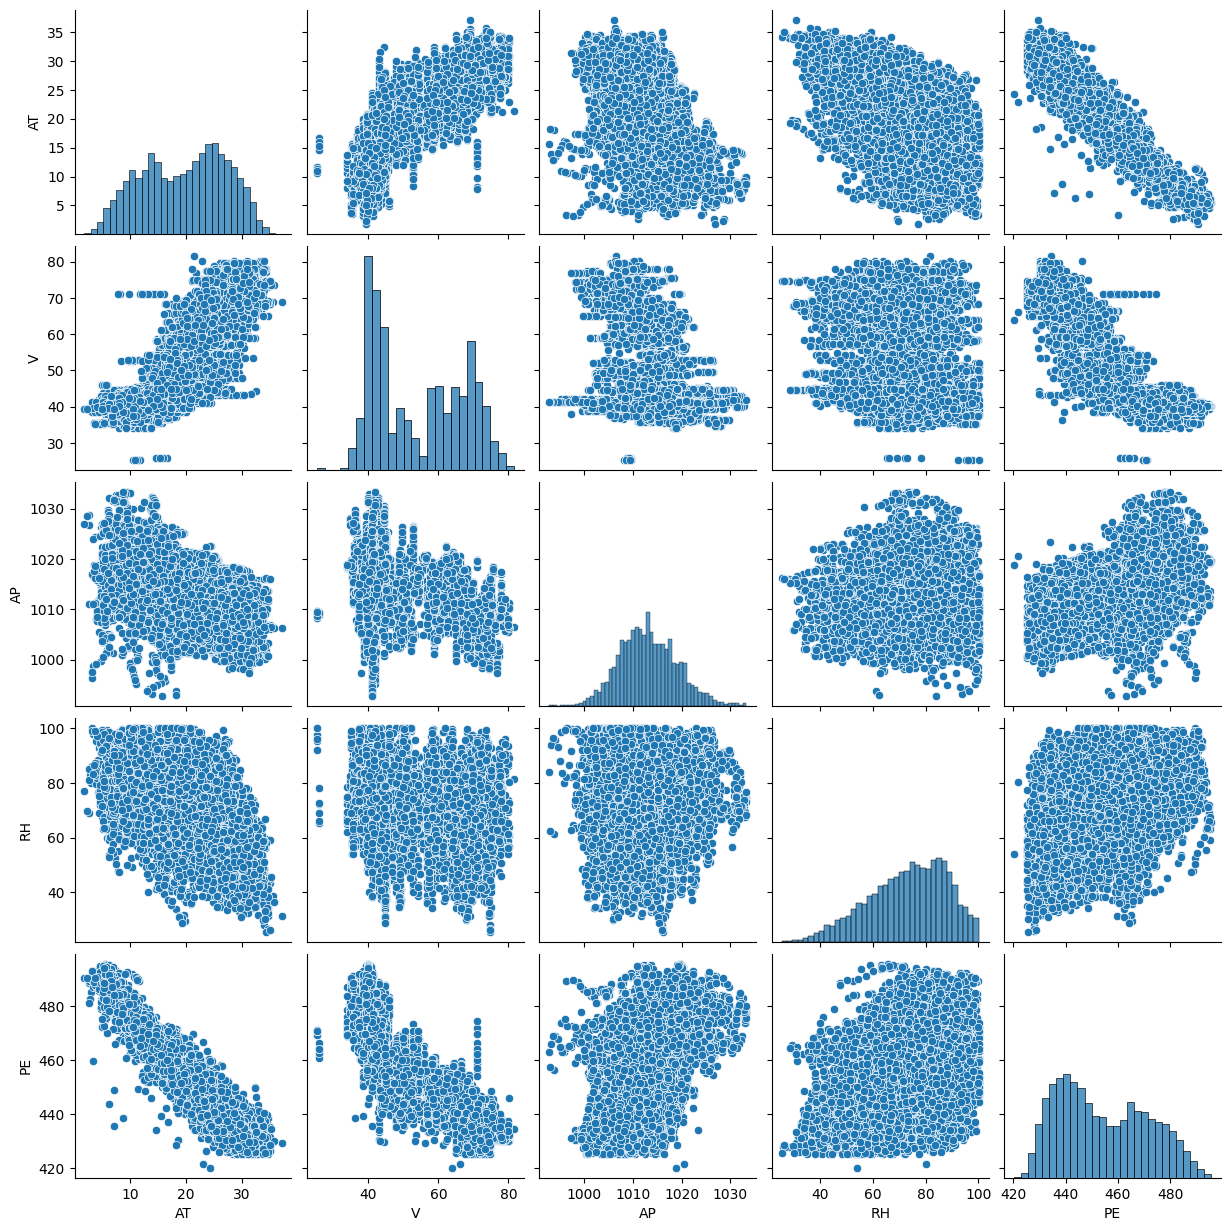

In [4]:
sns.pairplot(df_cpp)

There are "more linear-like" relationship bwteeen (AT, PE), (V, PE) compared with (AP, PH), (RH, PE).

When fitting simple linear regression with AT, V on PE, it is more possible that the linear model is a good fit.

Also, there is a "linear-like" relationship between AT and V. Thus, it is necessary to be careful to include these 2 predictors at the same time in multiple regression.

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [5]:
C_STAT_METRICS = ['variable', 'mean', 'median', 'range', 'first_quartile', 'third_quartile', 'IQR']

df_cpp_stat_metrics = pd.DataFrame([[column, df_cpp[column].mean(), df_cpp[column].median(), df_cpp[column].max() - df_cpp[column].min(),\
                                     df_cpp[column].quantile(0.25), df_cpp[column].quantile(0.75), df_cpp[column].quantile(0.75) - df_cpp[column].quantile(0.25)]\
                                    for column in df_cpp.columns.tolist()],\
                                   columns=C_STAT_METRICS)
print(df_cpp_stat_metrics)

  variable         mean    median  range  first_quartile  third_quartile  \
0       AT    19.651231    20.345  35.30         13.5100           25.72   
1        V    54.305804    52.080  56.20         41.7400           66.54   
2       AP  1013.259078  1012.940  40.41       1009.1000         1017.26   
3       RH    73.308978    74.975  74.60         63.3275           84.83   
4       PE   454.365009   451.550  75.50        439.7500          468.43   

       IQR  
0  12.2100  
1  24.8000  
2   8.1600  
3  21.5025  
4  28.6800  


### (c) Simple Linear Regression

#### Fit simple linear regression

Assumptions for each simple linear regression:

$PE = \beta_0 + \beta_1 AT + \epsilon$

$PE = \beta_0 + \beta_1 V + \epsilon$

$PE = \beta_0 + \beta_1 AP + \epsilon$

$PE = \beta_0 + \beta_1 RH + \epsilon$

In [6]:
def _format_model_summary(summary) -> pd.DataFrame:
    """
    Format the output of model.summary() into a dataframe like:
    |       |     coef |   std err |        t |   P>|t| |   [0.025 |   0.975] |
    |:------|---------:|----------:|---------:|--------:|---------:|---------:|
    | const |   ...    |     ...   |    ...   |   ...   |   ...    |    ...   |
    | X1    |   ...    |     ...   |    ...   |   ...   |   ...    |    ...   |
    | X2    |   ...    |     ...   |    ...   |   ...   |   ...    |    ...   |
    | ...   |   ...    |     ...   |    ...   |   ...   |   ...    |    ...   |
    Args:
    summary: summary got from model.summary()
    Return: df_results
    """
    df_results = pd.DataFrame(model.summary().tables[1].data)
    # Set first line of array as column names
    df_results.columns = df_results.iloc[0]

    # Drop first line (column names), set first column as index, change data type
    df_results = df_results.drop(0).set_index(df_results.columns[0]).astype(float)
    return df_results

In [7]:
V_ALPHA = 0.05 # set significance level as 0.05

C_PREDICTORS = df_cpp.columns.tolist()[0:-1]
C_RESPONSE = df_cpp.columns.tolist()[-1]

df_simple_regression_results = pd.DataFrame()
df_simple_regression_prediction = pd.DataFrame()

for predictor in C_PREDICTORS:
    X = df_cpp[predictor]
    y = df_cpp[C_RESPONSE]

    # Add a constant to the predictor variable
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Save the simple regression result
    df_simple_regression_results = pd.concat([df_simple_regression_results,\
                                              _format_model_summary(model.summary())])

    # Save the simple regression prediction
    df_simple_regression_prediction[predictor] = model.predict(X)

# Display simply regression results
print(df_simple_regression_results)

0           coef  std err         t  P>|t|    [0.025    0.975]
                                                              
const   497.0341    0.156  3177.280    0.0   496.727   497.341
AT       -2.1713    0.007  -291.715    0.0    -2.186    -2.157
const   517.8015    0.378  1370.218    0.0   517.061   518.542
V        -1.1681    0.007  -172.402    0.0    -1.181    -1.155
const -1055.2610   25.459   -41.449    0.0 -1105.167 -1005.355
AP        1.4899    0.025    59.296    0.0     1.441     1.539
const   420.9618    0.823   511.676    0.0   419.349   422.574
RH        0.4557    0.011    41.399    0.0     0.434     0.477


In the simple linear regressions of each predictor, the $p-value$ of each predcitor approximately equals to 0.0, which is < 0.05 ($\alpha$ that set beforehand). 

Thus, the coefficients of 4 predicots , $AT, V, AP, RH$, are **all statistically significant**.

#### Plot regression line

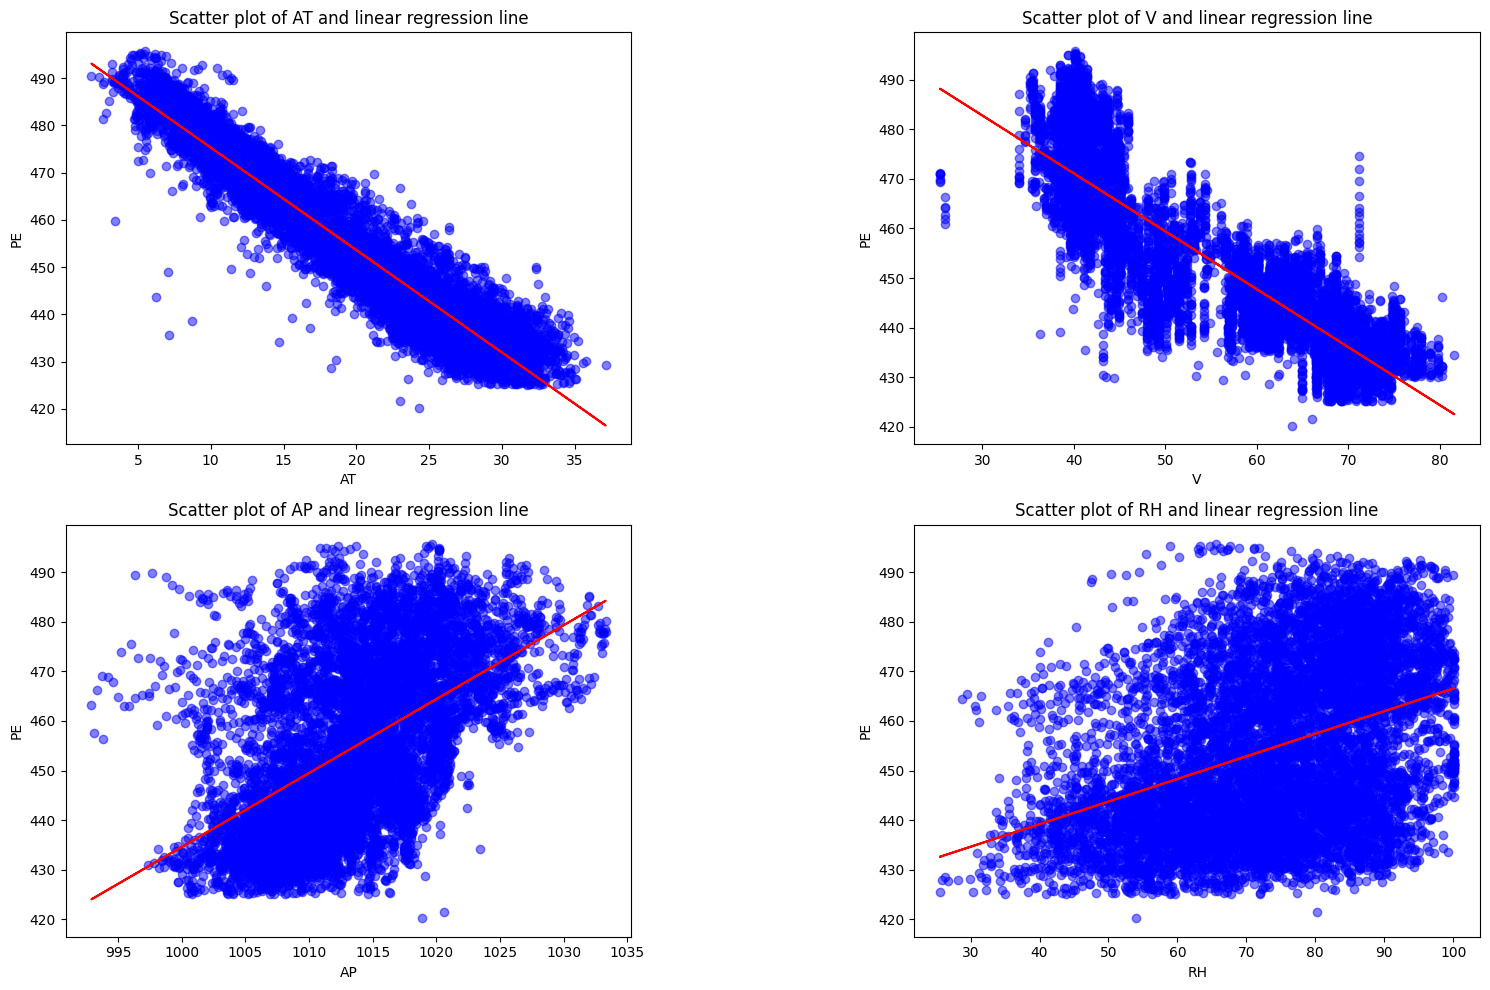

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, predictor in enumerate(C_PREDICTORS):

    row = i // 2
    column = i % 2
    predictor = C_PREDICTORS[i]

    # Plot the data points
    axes[row, column].scatter(df_cpp[predictor], df_cpp[C_RESPONSE], color='blue', label='Data Points', alpha=0.5)

    # Plot the regression line
    axes[row, column].plot(df_cpp[predictor], df_simple_regression_prediction[predictor], color='red', label='Regression Line')

    # Add title and labels
    axes[row, column].set_title(f'Scatter plot of {predictor} and linear regression line')
    axes[row, column].set_xlabel(predictor)
    axes[row, column].set_ylabel(C_RESPONSE)


plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  # Adjust spacing between subplots
plt.show()

In the scatter plots and simple linear regression lines above, the relationship between predictor $AT$ and response $PE$ and the relationship between predictor $V$ and response $PE$ fits the linear regression line better.

The relationships between $AP$ and $PE$ and relationship between $RH$ and $PE$ are more complex, but the coefficients of simple linear regression are still statistically significant. This might due to large dataset.

It is neccessary to dig into the non-linear relationships further.

#### Remove Outliers

Data points outside of 1.5 times the IQR above the third quartile and below the first quartile are considered as outliers.

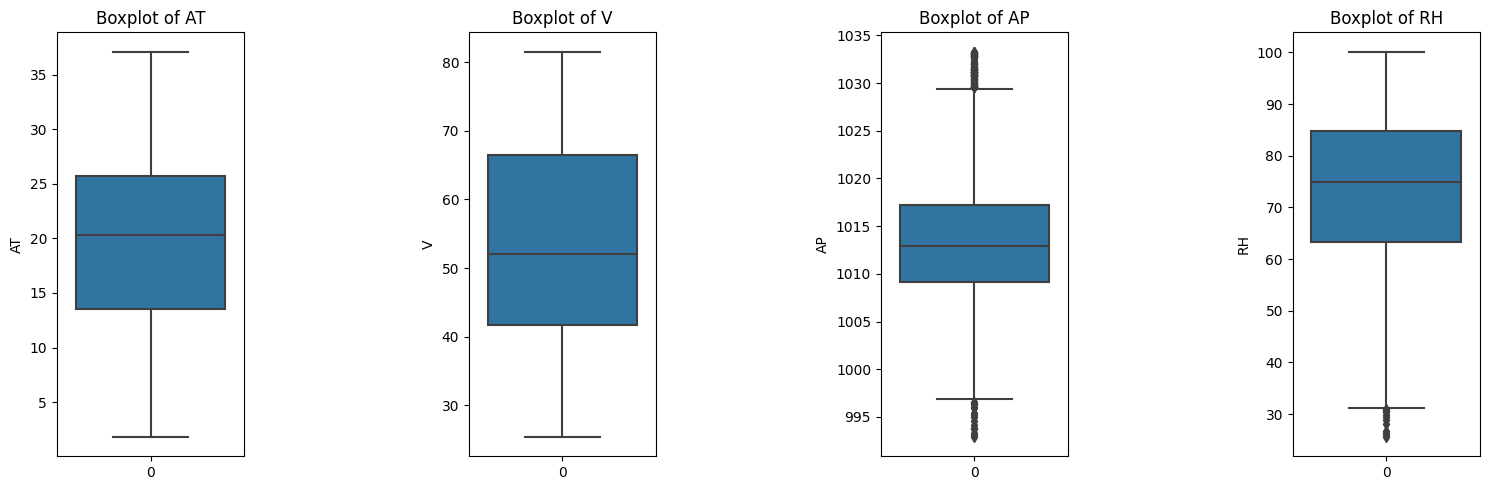

In [9]:
# Before removing outilers
fig, axes = plt.subplots(nrows=1, ncols=len(C_PREDICTORS), figsize=(15, 5))

for i, predictor in enumerate(C_PREDICTORS):
    sns.boxplot(df_cpp[predictor], ax=axes[i])
    axes[i].set_title(f'Boxplot of {predictor}')
    axes[i].set_ylabel(predictor)

plt.tight_layout()
plt.subplots_adjust(wspace=1.2)  # Adjust spacing between subplots
plt.show()

There are outilers for predictor $AP$ and $RH$.

In [10]:
# Remove outilers which are out of the range
Q1 = df_cpp[C_PREDICTORS].quantile(0.25)
Q3 = df_cpp[C_PREDICTORS].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows with outliers
filtered_df_cpp = df_cpp[~((df_cpp[C_PREDICTORS] < lower_bound) |\
                           (df_cpp[C_PREDICTORS] > upper_bound)).any(axis=1)]

print(filtered_df_cpp)

print(f"Removed {df_cpp.shape[0] - filtered_df_cpp.shape[0]} outliers")

         AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9468 rows x 5 columns]
Removed 100 outliers


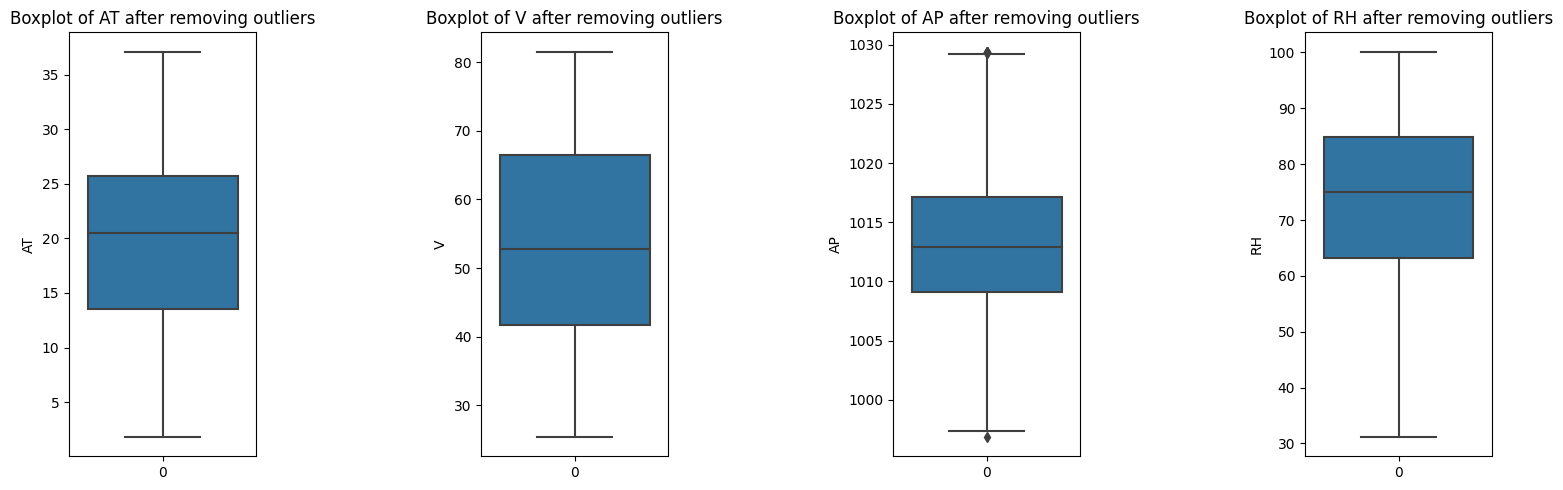

In [11]:
# After removing outilers
fig, axes = plt.subplots(nrows=1, ncols=len(C_PREDICTORS), figsize=(15, 5))

for i, predictor in enumerate(C_PREDICTORS):
    sns.boxplot(filtered_df_cpp[predictor], ax=axes[i])
    axes[i].set_title(f'Boxplot of {predictor} after removing outliers')
    axes[i].set_ylabel(predictor)

plt.tight_layout()
plt.subplots_adjust(wspace=1.2)  # Adjust spacing between subplots
plt.show()

### (d) Multiple Regression

#### Fit multiple regression

Assumption:

$PE = \beta_0 + \beta_1 AT + \beta_2 V + \beta_3 AP + \beta_4 RH + \epsilon$

In [12]:
X = df_cpp[C_PREDICTORS] # set X as all predictors
y = df_cpp[C_RESPONSE]

# Add a constant to the predictor variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

df_multi_regression_results = _format_model_summary(model.summary())

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:18:55   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

In [13]:
print(df_multi_regression_results)

0          coef  std err        t  P>|t|   [0.025   0.975]
                                                          
const  454.6093    9.749   46.634    0.0  435.500  473.718
AT      -1.9775    0.015 -129.342    0.0   -2.007   -1.948
V       -0.2339    0.007  -32.122    0.0   -0.248   -0.220
AP       0.0621    0.009    6.564    0.0    0.044    0.081
RH      -0.1581    0.004  -37.918    0.0   -0.166   -0.150


According to the regression summary above, the $p-value$ of all predictors are < 0.05 ($\alpha$ that set beforehand).

Thus, in multiple regression, the coefficients of predicotrs $AT$, $V$, $AP$, and $RH$ can all reject the null hypothesis $H_0: \beta_j=0$ at the significance level of 0.05.

### (e) 1c Compare to 1d

#### Compare coefficients of simple linear regression and multiple regression

In [14]:
C_COEF = 'coef'
C_SIMPLE_COEF = 'simple_coef'
C_MULTI_COEF = 'multi_coef'

df_comparison = pd.DataFrame()
df_comparison[C_SIMPLE_COEF] = df_simple_regression_results.loc[C_PREDICTORS][C_COEF]
df_comparison[C_MULTI_COEF] = df_multi_regression_results.loc[C_PREDICTORS][C_COEF]


print(df_comparison)

    simple_coef  multi_coef
                           
AT      -2.1713     -1.9775
V       -1.1681     -0.2339
AP       1.4899      0.0621
RH       0.4557     -0.1581


#### Plot coefficients of simple linear regression and multiple regression

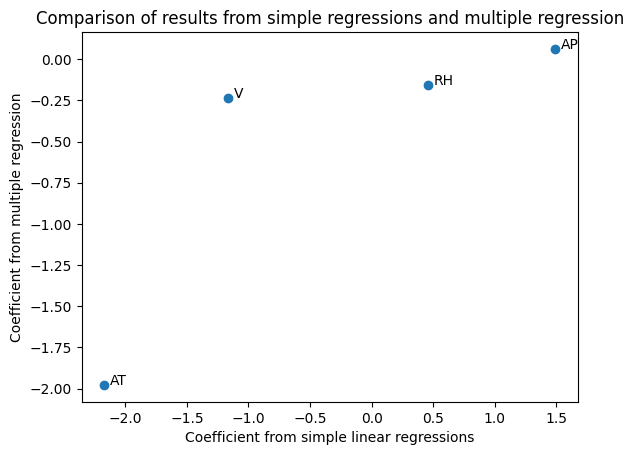

In [15]:
# Plot results of simple and multiple regression
plt.scatter(df_comparison[C_SIMPLE_COEF], df_comparison[C_MULTI_COEF])

# Annotate each point with its index
for index, row in df_comparison.iterrows():
    plt.annotate(index, (row[C_SIMPLE_COEF] + 0.05, row[C_MULTI_COEF]))

# Add title and labels
plt.title("Comparison of results from simple regressions and multiple regression")
plt.xlabel("Coefficient from simple linear regressions")
plt.ylabel("Coefficient from multiple regression")

# Display the plot
plt.show()

### (f) Nonlinear Association

Use ```PolynomialFeatures()``` to generate polynomial features for each predictor.

Assumptions for each regression:

$PE = \beta_0 + \beta_1 AT + \beta_2 AT^2 + \beta_3 AT^3 + \epsilon$

$PE = \beta_0 + \beta_1 V + \beta_2 V^2 + \beta_3 V^3 + \epsilon$

$PE = \beta_0 + \beta_1 AP + \beta_2 AP^2 + \beta_3 AP^3 + \epsilon$

$PE = \beta_0 + \beta_1 RH + \beta_2 RH^2 + \beta_3 RH^3 + \epsilon$

Ref:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

#### Fit linear regression with polynomial features

In [16]:
V_POLYNOMIAL_DEGREE = 3

df_polynomial_features = pd.DataFrame()
df_polynomial_regression_results = pd.DataFrame()
df_polynomial_regression_prediction = pd.DataFrame()
polynomial_features= PolynomialFeatures(degree=V_POLYNOMIAL_DEGREE)


for predictor in C_PREDICTORS:
    X = pd.DataFrame(df_cpp[predictor])
    # Create polynomial features for predictor
    poly_columns = ['const', predictor, f'{predictor}^2', f'{predictor}^3']
    XP = pd.DataFrame(polynomial_features.fit_transform(X), columns=poly_columns)

    # Save polynomial features
    df_polynomial_features = pd.concat([df_polynomial_features, XP.drop(columns=['const'])], axis=1)

    y = df_cpp[C_RESPONSE]

    model = sm.OLS(y, XP).fit()

    # Save polynomial regression results
    df_polynomial_regression_results = pd.concat([df_polynomial_regression_results,\
                                                _format_model_summary(model.summary())])
    
    # Save polynomial regression predictions
    df_polynomial_regression_prediction[predictor] = model.predict(XP)

    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:18:56   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

#### Plot regression line

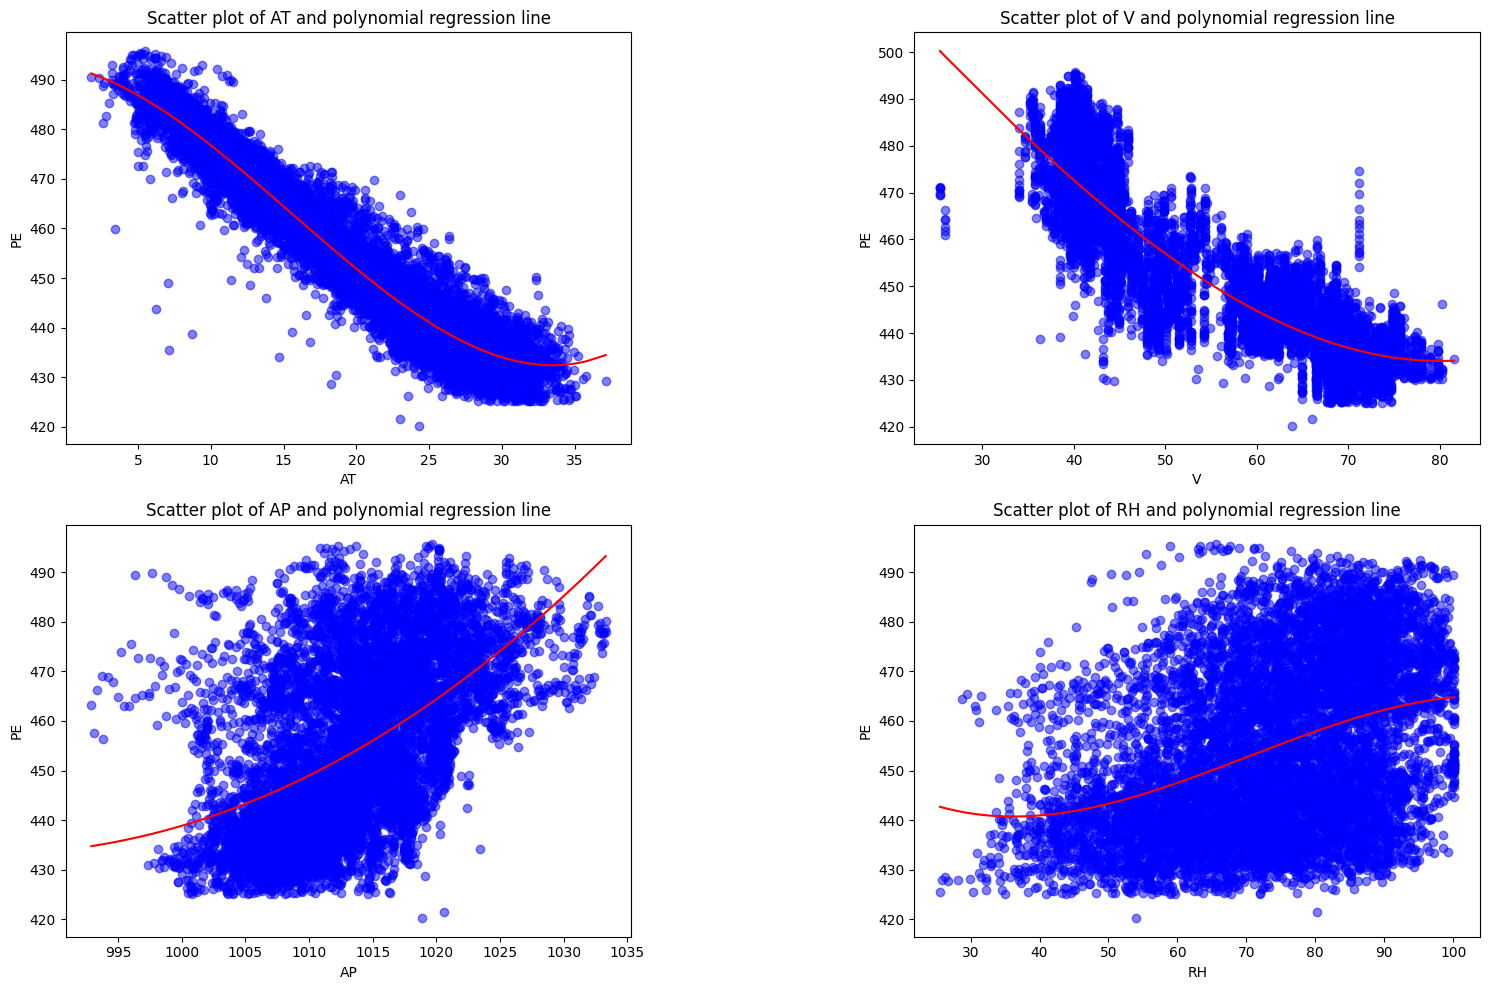

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, predictor in enumerate(C_PREDICTORS):

    row = i // 2
    column = i % 2

    # Plot the data points
    axes[row, column].scatter(df_cpp[predictor], df_cpp[C_RESPONSE], color='blue', label='Data Points', alpha=0.5)

    # Plot the regression line
    sorted_order = np.argsort(df_cpp[predictor])
    
    axes[row, column].plot(df_cpp[predictor].iloc[sorted_order].values,\
                           df_polynomial_regression_prediction[predictor][sorted_order],\
                           color='red', label='Regression Line')

    # Add title and labels
    axes[row, column].set_title(f'Scatter plot of {predictor} and polynomial regression line')
    axes[row, column].set_xlabel(predictor)
    axes[row, column].set_ylabel(C_RESPONSE)


plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  # Adjust spacing between subplots
plt.show()

In [18]:
print(df_polynomial_regression_results)

0            coef    std err        t  P>|t|      [0.025      0.975]
                                                                    
const  492.728100   0.673000  732.248  0.000  491.409000  494.047000
AT      -0.610300   0.124000   -4.941  0.000   -0.852000   -0.368000
AT^2    -0.125100   0.007000  -18.199  0.000   -0.139000   -0.112000
AT^3     0.002700   0.000000   22.594  0.000    0.002000    0.003000
const  554.146800   9.151000   60.557  0.000  536.209000  572.084000
V       -2.144400   0.509000   -4.214  0.000   -3.142000   -1.147000
V^2     -0.002700   0.009000   -0.294  0.768   -0.021000    0.015000
V^3      0.000100   0.000055    2.465  0.014    0.000028    0.000000
const    0.074700   0.009000    8.415  0.000    0.057000    0.092000
AP      25.255600   3.001000    8.415  0.000   19.372000   31.139000
AP^2    -0.050000   0.006000   -8.439  0.000   -0.062000   -0.038000
AP^3     0.000025   0.000003    8.613  0.000    0.000019    0.000031
const  468.413500  10.545000   44.

Results of fitting models including polynomial features of each predictors shows that the coefficients of $AT, AP, RH$ and their corresponding polynomial features are all statistically significant. Thus, there are significant non-linear relation between response variable $PE$ and each of $AT, AP, RH$.

The $p-value$ of $V^2$ is > 0.05 while $p-value$ of $V^3$ is < 0.05, which means that in this case the cubed term of $V$ can better explain the non-linearity between $V$ and  $PE$ than that of squared one.

In the plot, the linear regression with polynomial features of $AT$ and $V$ demonstrate better fit to the relationship between predictor and response. Although the $p-value$ of $AP$ and $RH$ (including their polynomial features) are < $\alpha$ (0.05), it is hard to explain the fitted line.

### (g) Interactions of Predictors

#### Fit linear regression with all interactions

In [19]:
df_interactions = df_cpp[C_PREDICTORS].copy(deep=True)

# Get the interactions between each two predictors
for i in range(len(C_PREDICTORS)):
    for j in range(i + 1, len(C_PREDICTORS)):
        interaction_term = f'{C_PREDICTORS[i]} * {C_PREDICTORS[j]}'
        df_interactions[interaction_term] = df_interactions[C_PREDICTORS[i]] * df_interactions[C_PREDICTORS[j]]

X = df_interactions
y = df_cpp[C_RESPONSE]

# Add a constant to the predictor variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:18:57   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

In the above model including all possible interaction terms, $p-value$ of predictors $V, AP, RH, AT*V, AT*RH, V*AP, AP*RH$ < 0.05. Thus, the coefficient of these predictors are statistically significant.

Because $p-value$ of $AT, AT*AP, V*RH$ are > 0.05, predictors in the model will be reselected later based on **backforward selection**.

The variable with the largest $p-value$, which is the least statistically significant, will be removed from the model.

Then new model is fit, continue the above process until all remaining variables have a $p-value$ < 0.05.

#### Backward selection

The stopping rule is set as all the remaining variables are statistically significant. Thus, **hiearchy rule** (keep the main factor when any of interactions are included) **is not applied** here. 

The only indicator of whether to keep or remove a variable is its $p-value$.

In [20]:
while max(model.pvalues) > V_ALPHA:
    # Drop the predictor with the highest p-value
    drop_variable = model.pvalues.idxmax()
    print(f"Drop variable: {drop_variable} (p-value: {round(model.pvalues.max(), 2)})")
    X = X.drop(drop_variable, axis=1)

    # Refit the model
    model = sm.OLS(y, X).fit()

print('\n', _format_model_summary(model.summary()))

Drop variable: AT * AP (p-value: 0.45)
Drop variable: V * RH (p-value: 0.1)
Drop variable: AP (p-value: 0.08)

 0            coef  std err        t  P>|t|   [0.025   0.975]
                                                            
const    527.9313    1.328  397.533    0.0  525.328  530.535
AT        -2.5526    0.061  -41.596    0.0   -2.673   -2.432
V         -7.0266    0.526  -13.363    0.0   -8.057   -5.996
RH         2.8639    0.339    8.450    0.0    2.200    3.528
AT * V     0.0199    0.001   25.077    0.0    0.018    0.021
AT * RH   -0.0047    0.000   -9.822    0.0   -0.006   -0.004
V * AP     0.0063    0.001   12.217    0.0    0.005    0.007
AP * RH   -0.0029    0.000   -8.559    0.0   -0.004   -0.002


3 varibles are removed in the sequence of $AT * AP, V * RH, AP$.

### (h) Improvement

In [21]:
df_all_features = pd.concat([df_polynomial_features, df_interactions.drop(columns=C_PREDICTORS)], axis=1)
print(df_all_features)

         AT      AT^2          AT^3      V        V^2            V^3       AP  \
0     14.96  223.8016   3348.071936  41.76  1743.8976   72825.163776  1024.07   
1     25.18  634.0324  15964.935832  62.96  3963.9616  249571.022336  1020.04   
2      5.11   26.1121    133.432831  39.40  1552.3600   61162.984000  1012.16   
3     20.86  435.1396   9077.012056  57.32  3285.5824  188329.583168  1010.24   
4     10.82  117.0724   1266.723368  37.50  1406.2500   52734.375000  1009.23   
...     ...       ...           ...    ...        ...            ...      ...   
9563  16.65  277.2225   4615.754625  49.69  2469.0961  122689.385209  1014.01   
9564  13.19  173.9761   2294.744759  39.18  1535.0724   60144.136632  1023.67   
9565  31.32  980.9424  30723.115968  74.33  5524.9489  410669.451737  1012.92   
9566  24.48  599.2704  14670.139392  69.45  4823.3025  334978.358625  1013.86   
9567  21.60  466.5600  10077.696000  62.52  3908.7504  244375.075008  1017.23   

              AP^2         

#### Train model with **all predictors**

Similar to 1.(d)

##### Split into training set and test sets

Use train_test_split() to randomly split data points into training set and test set.

Select 70% subset of the data as training set. Set ```random_state = 42``` for reproducible output across multiple function calls.

Ref:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [22]:
V_TEST_SIZE = 0.3
V_RANDOM_STATE = 42

X = df_cpp[C_PREDICTORS]
y = df_cpp[C_RESPONSE]

# Add a constant to the predictor variable
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=V_TEST_SIZE, random_state=V_RANDOM_STATE)

##### Train model

In [23]:
# Fit the regression model
multi_linear_model = sm.OLS(y_train, X_train).fit()
print(multi_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.194e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:18:57   Log-Likelihood:                -19630.
No. Observations:                6697   AIC:                         3.927e+04
Df Residuals:                    6692   BIC:                         3.930e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        467.8414     11.502     40.673      0.0

##### Calculate MSE

In [24]:
def _cal_MSE(y_actual: pd.DataFrame, y_pred: np.ndarray) -> float:
  """
  Calculate mean squared error.
  Args:
    y_actual: actual value of y
    y_pred: predicted value of y
  Return: mse
  """
  return sum((y_actual - y_pred) ** 2) / y_actual.shape[0]

In [25]:
C_MSE_TRAIN = 'train_MSE_multi'
C_MSE_TEST = 'test_MSE_multi'

df_multi_linear_mse = pd.DataFrame([{C_MSE_TRAIN: _cal_MSE(y_train, multi_linear_model.predict(X_train)),\
                                        C_MSE_TEST: _cal_MSE(y_test, multi_linear_model.predict(X_test))}])

print(df_multi_linear_mse)

   train_MSE_multi  test_MSE_multi
0         20.58084       21.239857


#### Train with **all interaction terms and quadratic nonlinearities**

1. Train a linear model with all possible interation terms (6 possible terms) and all quandratic nonlinearities (4 nonlinearities)

2. Select siginificant variables using **backward selection**. Remove the variable with the **largest** $p-value$.

3. Fit a new model with remaining variables. If there are still insignificant variables, continue the preivous steps. Loop until **all remaining variables are significant**.

##### Split into training and test sets

Same as previous splitting method.

In [26]:
# Choose all interactions and quadratic nonlinearities
X_all = df_all_features.drop(columns=['AT^3', 'V^3', 'AP^3', 'RH^3'])
y = df_cpp[C_RESPONSE]

# Add a constant to the predictor variable
X_all = sm.add_constant(X_all)

X_all_train, X_all_test, y_train, y_test = train_test_split(X_all, y, test_size=V_TEST_SIZE, random_state=V_RANDOM_STATE)

##### Train model and make backward selection

In [27]:
# Fit the regression model
all_model = sm.OLS(y_train, X_all_train).fit()

print(all_model.summary())

print("\nStart backward selection!")

while max(all_model.pvalues) > V_ALPHA:
    # Drop the predictor with the highest p-value
    drop_variable = all_model.pvalues.idxmax()
    print(f"\nDrop variable: {drop_variable} (p-value: {round(all_model.pvalues.max(), 2)})")
    X_all_train = X_all_train.drop(drop_variable, axis=1)

    # Refit the model
    all_model = sm.OLS(y_train, X_all_train).fit()

print("\nBackward selection finished. \nRemaing variables:", X_all_train.columns.tolist(), '\n')
print(all_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7272.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:18:58   Log-Likelihood:                -19160.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6682   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7664.9809   1429.568     -5.362      0.0

3 varibles are removed in the sequence of $V * RH, V^2, V * AP$.

##### Calculate MSE

In [28]:
C_MSE_TRAIN = 'train_MSE_all'
C_MSE_TEST = 'test_MSE_all'

# Remove dropped variables from test set
X_all_test = X_all_test[X_all_train.columns.tolist()]

df_all_mse = pd.DataFrame([{C_MSE_TRAIN: _cal_MSE(y_train, all_model.predict(X_all_train)),\
                                    C_MSE_TEST: _cal_MSE(y_test, all_model.predict(X_all_test))}])

print(df_all_mse)

   train_MSE_all  test_MSE_all
0      17.890843      18.66004


#### Compare test errors of 2 models

In [29]:
print(pd.concat([df_multi_linear_mse, df_all_mse], axis=1))

   train_MSE_multi  test_MSE_multi  train_MSE_all  test_MSE_all
0         20.58084       21.239857      17.890843      18.66004


Test error of linear regression with quadratic nonlinearities and interactions (18.66) is **less than** that of linear regression with all predictors (21.24).

Thus, **model with quadratic nonlinearities and interactions performs better** in predicting test set.

Based on the results from 1.(f) and 1.(g), the coefficients of some quadratic nonlinearities (e.g., $AT^2$) and interactions (e.g., $AT*V$) are statistically significant, which means that there is non-linearity between predictors and response. That's why model with polynomial features and interactions gets a better MSE.

### (i) KNN

#### Normalize features

Use ```MinMaxScalar()``` to normalize features. 

According to histograms in (b)(ii), the distribution of predictors **might not be Gaussian**. Thus, ```MinMaxScalar()``` is applied rather than ```StandardScalar()```.

Ref:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

In [30]:
X = df_cpp[C_PREDICTORS]
y = df_cpp[C_RESPONSE]

# Add a constant to the predictor variable
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=V_TEST_SIZE, random_state=V_RANDOM_STATE)

In [31]:
scaler = MinMaxScaler()
norm_X = scaler.fit_transform(X)

# Add a constant to the predictor variable
norm_X = sm.add_constant(norm_X)

norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=V_TEST_SIZE, random_state=V_RANDOM_STATE)

In [39]:
norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.3, random_state=2)

#### Train model with raw features

Use ```KNeighborsRegressor()``` to perform k-nearest neighbor regression.

Ref:

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

In [32]:
C_MSE_TRAIN = 'train_MSE'
C_MSE_TEST = 'test_MSE'

V_K_START = 1 # set start value of k as 1
V_K_END = 100 # set end value of k as 100
knn_raw_reaults = {}

for k in range(V_K_START, V_K_END + 1):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    # Predict with KNN regressor
    pred_train = neigh.predict(X_train)
    pred_test = neigh.predict(X_test)

    # Calculate MSE
    knn_raw_reaults[k] = [_cal_MSE(y_train, pred_train), _cal_MSE(y_test, pred_test)]

df_knn_raw_results = pd.DataFrame(knn_raw_reaults, index=[C_MSE_TRAIN, C_MSE_TEST]).T

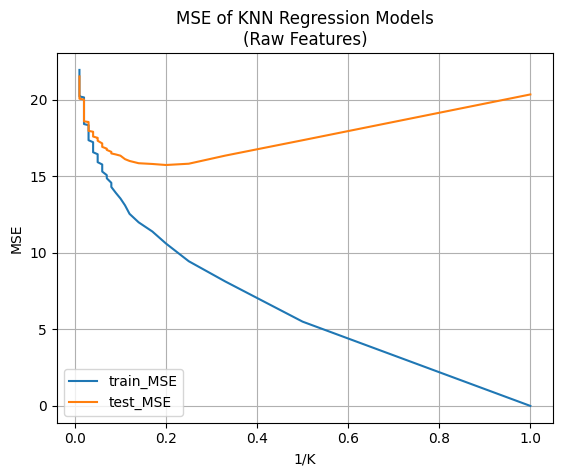

In [33]:
# Plot trend of train MSE and test MSE
plt.plot([round(1 / k, 2) for k in range(V_K_START, V_K_END + 1)], df_knn_raw_results[C_MSE_TRAIN], label=C_MSE_TRAIN)
plt.plot([round(1 / k, 2) for k in range(V_K_START, V_K_END + 1)], df_knn_raw_results[C_MSE_TEST], label=C_MSE_TEST)

plt.title("MSE of KNN Regression Models\n(Raw Features)")
plt.xlabel("1/K")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.show()

When $k=5$, MSE of test set is minimum. 

When $k$ is too small (e.g., $k=1$), the prediction results of training set will be good (train MSE is close to 0) while test MSE is large. That's because the model overfit to the training data.

When $k$ is too large, both train MSE and test MSE are large because the model is too general.

#### Train model with normalized features

In [34]:
C_MSE_TRAIN = 'train_MSE'
C_MSE_TEST = 'test_MSE'

knn_norm_reaults = {}

for k in range(V_K_START, V_K_END + 1):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(norm_X_train, y_train)
    # Predict with KNN regressor
    pred_train = neigh.predict(norm_X_train)
    pred_test = neigh.predict(norm_X_test)

    # Calculate MSE
    knn_norm_reaults[k] = [_cal_MSE(y_train, pred_train), _cal_MSE(y_test, pred_test)]

df_knn_norm_results = pd.DataFrame(knn_norm_reaults, index=[C_MSE_TRAIN, C_MSE_TEST]).T

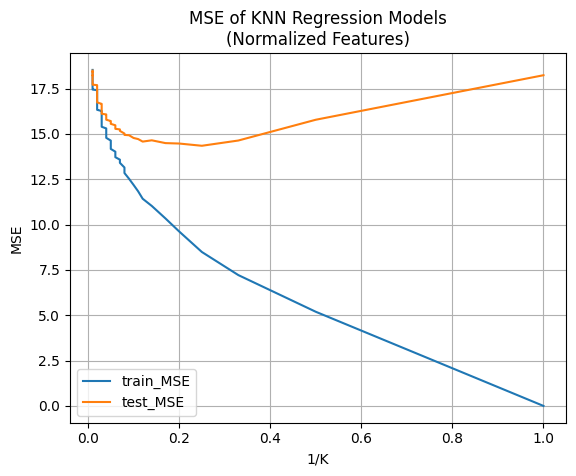

In [35]:
# Plot trend of train MSE and test MSE
plt.plot([round(1 / k, 2) for k in range(V_K_START, V_K_END + 1)], df_knn_norm_results[C_MSE_TRAIN], label=C_MSE_TRAIN)
plt.plot([round(1 / k, 2) for k in range(V_K_START, V_K_END + 1)], df_knn_norm_results[C_MSE_TEST], label=C_MSE_TEST)

plt.title("MSE of KNN Regression Models\n(Normalized Features)")
plt.xlabel("1/K")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.show()

When $k=4$, MSE of test set is minimum.

#### Compare raw features and normalized features

In [36]:
df_knn_raw_results = df_knn_raw_results.rename(columns={C_MSE_TRAIN: 'train_MSE_raw', C_MSE_TEST: 'test_MSE_raw'})

df_knn_norm_results = df_knn_norm_results.rename(columns={C_MSE_TRAIN: 'train_MSE_norm', C_MSE_TEST: 'test_MSE_norm'})

df_knn_results_comparison = pd.concat([df_knn_raw_results, df_knn_norm_results], axis=1)

print(df_knn_results_comparison)
print(df_knn_results_comparison.min(axis=0))

     train_MSE_raw  test_MSE_raw  train_MSE_norm  test_MSE_norm
1         0.000000     20.332543        0.000000      18.239453
2         5.500468     17.344087        5.193593      15.783890
3         8.126551     16.338840        7.216737      14.638276
4         9.444740     15.810755        8.489532      14.348653
5        10.600769     15.726820        9.624415      14.472256
..             ...           ...             ...            ...
96       21.777155     21.353818       18.410941      18.431318
97       21.829599     21.407387       18.446295      18.451387
98       21.857310     21.440896       18.480281      18.457115
99       21.894854     21.479490       18.508370      18.468876
100      21.933470     21.508311       18.532041      18.493085

[100 rows x 4 columns]
train_MSE_raw      0.000000
test_MSE_raw      15.726820
train_MSE_norm     0.000000
test_MSE_norm     14.348653
dtype: float64


According to the above comparison, KNN regressor fit with **normalized** features performs **better** than that with raw feature.

This might due to the difference among the scale of predictors. For example,

| variable   |      mean |   median |   range |   first_quartile |   third_quartile |   IQR |
|:-----------|----------:|---------:|--------:|-----------------:|-----------------:|------:|
| AT         |   19.6512 |   20.345 |   35.3  |            13.51 |            25.72 | 12.21 |
| V          |   54.3058 |   52.08  |   56.2  |            41.74 |            66.54 | 24.8  |
| AP         | 1013.26   | 1012.94  |   40.41 |          1009.1  |          1017.26 |  8.16 |

The mean of $AP$ is 50 times larger than mean of $AT$, which will make $AP$ dominate in the calculation of distances. 

Normalization can balance the effect of each predictor, which can help KNN Regression get better results.

### (j) Compare KNN and Linear

Compare the results of KNN Regression with the linear regression model that has the smallest test error.

Based on the comparsion of 1.(h), **linear regression model that has the smallest test error is the one includes polynomial features and interactions (selected by backward selection)**.

In [38]:
print("Compare KNN and Linear Regression")
print(pd.concat([df_all_mse,\
                 df_knn_raw_results.iloc[[df_knn_raw_results['test_MSE_raw'].idxmin()]].reset_index(drop=True),
                 df_knn_norm_results.iloc[[df_knn_norm_results['test_MSE_norm'].idxmin()]].reset_index(drop=True)],\
                axis=1))

Compare KNN and Linear Regression
   train_MSE_all  test_MSE_all  train_MSE_raw  test_MSE_raw  train_MSE_norm  \
0      17.890843      18.66004      11.387236     15.794225        9.624415   

   test_MSE_norm  
0      14.472256  


In most cases, when dimension of predictors $p$ is relatively high, KNN Regression performs inferior to linear regression. $^1$

However, in this case, KNN Regression gets a smaller test MSE than linear regression. 

This might because linear regression with **quadratic nonlinearities and interactions** is **more sensitive to "noise"** in data. 

While KNN Regression with a sutiable $k$ can be more robust to "noise".

Or in this case, KNN Regression might better explain the non-linearity between predictors and response.

Ref:

1. ISLR. 107-110

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

A flexible statistically learning method will perform **better** than an inflexible one.

When sample size is extremely large, there's enough information among variables in sample data. Thus, flexible learning method with more parameters **can better discover the complex relationship** between predictors and response variable.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

A flexible statistically learning method will perform **worse** than an inflexible one.

When sample size is small and the number of predictors is extremely large, flexible statistically learning methods may result in **overfitting**.

When the level of flexibility increases, the prediction will **fit the observed data better**. But, a **small sample cannot represent population**. Thus, in this case, a flexible statistically methods **might capture the noise** in the small sample. When it is applied to new samples (e.g., unknown test data), it will perform worse than a inflexible one.

### (c) The relationship between the predictors and response is highly non-linear.

A flexible statistically learning method will perform **better** than an inflexible one.

When the relationship between the predictors and response is highly non-linear, a flexible method (e.g., smoothing splines) can better capture the non-linearities with more parameters. Like below example:

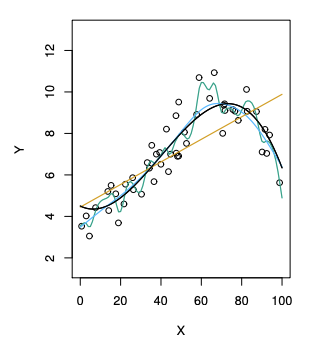

An inflexible statistically method (orange line, linear) cannot capture the highly on-linear relation while a flexible statistically method (blue line, non-linear) performs better.

Ref: ISLR. 31

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

A flexible statistically learning method perform **worse** than an inflexible one.

When the variance of the error terms is extremely high, both inflexible and flexible method will perform bad because Var($ϵ$) is **irreducible** in expectation of test MSE.

Under the comparison, when Var($ϵ$) is high, there is high randomness among data or there is more "noise" in data. Flexible statistically learning method will be **more likely to capture the "noise"** as patterm which **results in overfitting**. Thus, it will perform worse than an inflexible one.



## 3. ISLR: 2.4.7

| Obs. | _X1_ | _X2_ | _X3_ | _Y_   |
|------|------|------|------|-------|
| 1    | 0    | 3    | 0    | Red   |
| 2    | 2    | 0    | 0    | Red   |
| 3    | 0    | 1    | 3    | Red   |
| 4    | 0    | 1    | 2    | Green |
| 5    | -1   | 0    | 1    | Green |
| 6    | 1    | 1    | 1    | Red   |

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

The definition of Euclidean distance between $x=(x_1, x_2,..., x_n)$ and $y=(y_1, y_2,..., y_n)$ is

$d(x, y) = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2+...+(x_n - y_n)^2}$

Thus, the Euclidean distance between test point X1 = X2 = X3 = 0 with each observation are:

$d_1 = \sqrt{(0-0)^2 + (3-0)^2 + (0-0)^2} = 3$

$d_2 = \sqrt{(2-0)^2 + (0-0)^2 + (0-0)^2} = 2$

$d_3 = \sqrt{(0-0)^2 + (1-0)^2 + (3-0)^2} = \sqrt{10}$

$d_4 = \sqrt{(0-0)^2 + (1-0)^2 + (2-0)^2} = \sqrt{5}$

$d_5 = \sqrt{(-1-0)^2 + (0-0)^2 + (1-0)^2} = \sqrt{2}$

$d_6 = \sqrt{(1-0)^2 + (1-0)^2 + (1-0)^2} = \sqrt{3}$


### (b) What is our prediction with K = 1? Why?

With $K = 1$, the prediction of test point is Green. Because **observation 5** is the **nearest** neighbor with $K = 1$. Following the rule of majority polling, the prediction of test point is the **same as Y of observation 5** **bold text**.


### (c) What is our prediction with K = 3? Why?

With K = 3, the prediction of test point is Red. Because **observation 2, observersion 5, observation 6** are K-nearest neighbors of test point with K = 3. Observation 2 and observation 6 are Red, observation 5 is Green. Following **majority polling**, the prediction of test point is the same as the majority class of K-nearest neighbors, which is Red (2/3).


### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

We would expect the best value for K to be **small**.

A **small K** means that the classification of a data point is based on a small number of its closest neighbors, which makes the KNN classifier **more flexible** to the data.

In this case, the Bayes decision boundary is highly non-linear, which means the relationship between predictors and response is complex and non-linear. Thus, a more flexible KNN classifier (small K) can **better capture non-linearity**.

Like the example below:

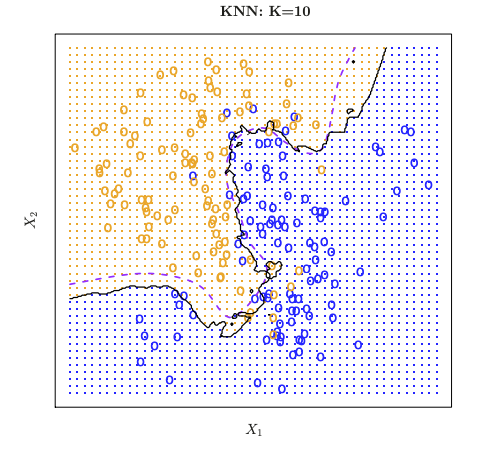


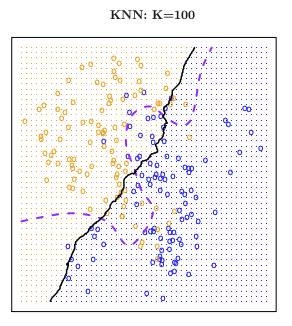

In the above example, a small K value (K=10) captures non-linearity better (close to the black Bayes decision boundary) than a large K value (K=100).


Ref: ISLR. 40-41